In [4]:
from __future__ import annotations

import abc
from abc import ABC, abstractmethod
import trieste
import tensorflow as tf
import numpy as np
from trieste.acquisition.interface import (
    AcquisitionFunction,
    SingleModelAcquisitionBuilder,
)
from typing import Optional, cast, Generic, TypeVar, Sequence, NamedTuple, Union, Tuple
from trieste.data import Dataset
from trieste.types import TensorType
from trieste.space import SearchSpace
import tensorflow_probability as tfp
from trieste.acquisition import AcquisitionFunctionClass
from trieste.objectives import scaled_branin
from trieste.models.gpflow.builders import build_gpr
from trieste.models.gpflow import GaussianProcessRegression
from trieste.models.interfaces import (
    ProbabilisticModel,
    TrainableProbabilisticModel,
)
from gpflow.logdensities import multivariate_normal
import gpflow
from gpflow.models import GPR
import math
import matplotlib.pyplot as plt
OBJECTIVE = "OBJECTIVE"

ProbabilisticModelType = TypeVar(
    "ProbabilisticModelType", bound="ProbabilisticModel", contravariant=True
)
import concurrent.futures
#from tensorflow.python.ops.numpy_ops import np_config
tf.experimental.numpy.experimental_enable_numpy_behavior()  # NOTE: This depends on tf 2.5 and trieste currently depends on 2.4
#np_config.enable_numpy_behavior()


In [5]:

# Feels like these functions kind of belong to the dataset, not the model. Why should the model be splitting datasets based on fidelity? Single responsibilty etc.
class MultiFidelityModel(TrainableProbabilisticModel):
    num_fidelities: int

    # def split_query_points_by_fidelity(self, query_points: TensorType) -> Sequence[TensorType]:
    #     fidelity_col = query_points[:, -1:]
    #     # check fidelity col are integers
    #
    #     # check they aren't any larger than the num_fidelities - 1

    def split_dataset_by_fidelity(self, dataset: Dataset) -> Sequence[Dataset]:
        datasets = []
        for fidelity in range(self.num_fidelities):
            dataset_i = get_dataset_for_fidelity(dataset, fidelity)
            datasets.append(dataset_i)
        return datasets


def get_dataset_for_fidelity(dataset: Dataset, fidelity: int) -> Dataset:
    input_points = dataset.query_points[:, :-1]  # [..., D+1]
    fidelity_col = dataset.query_points[:, -1]  # [...,]
    mask = (fidelity_col == fidelity)  # [..., ]
    inds = tf.where(mask)[:, 0]  # [..., ]
    inputs_for_fidelity = tf.gather(input_points, inds, axis=0)  # [..., D]
    observations_for_fidelity = tf.gather(dataset.observations, inds, axis=0)  # [..., 1]
    return Dataset(query_points=inputs_for_fidelity, observations=observations_for_fidelity)


def convert_query_points_for_fidelity(query_points: TensorType, fidelity: int) -> TensorType:
    fidelity_col = tf.ones((tf.shape(query_points)[0], 1), dtype=query_points.dtype)*fidelity
    query_points_for_fidelity = tf.concat([query_points, fidelity_col], axis=-1)
    return query_points_for_fidelity


In [11]:
#def build_ar1_submodels(data: Dataset, search_space: SearchSpace, num_fidelities: int) -> Sequence[GaussianProcessRegression]:
#    return [build_gpr(data=)]


class AR1(MultiFidelityModel):
    def __init__(
            self,
            lowest_fidelity_signal_model: GaussianProcessRegression,
            fidelity_residual_models: Sequence[GaussianProcessRegression],
    ):
        # check some things
        #assert len(fidelity_signal_models) == len(fidelity_residual_models) + 1
        self.num_fidelities = len(fidelity_residual_models) + 1

        self.lowest_fidelity_signal_model = lowest_fidelity_signal_model
        self.fidelity_residual_models: Sequence[Union[Optional[GaussianProcessRegression]]] = [None, *fidelity_residual_models]
        # set this as a Parameter so that we can optimize it
        rho = [gpflow.Parameter(1.0, trainable=True, name=f'rho_{i}')
                    for i in range(self.num_fidelities - 1)]
        self.rho = [1, *rho]

    def predict(self, query_points: TensorType) -> tuple[TensorType, TensorType]:
        query_points_wo_fidelity = query_points[:, :-1]
        query_points_fidelity_col = query_points[:, -1:]

        signal_mean, signal_var = self.lowest_fidelity_signal_model.predict(query_points_wo_fidelity)

        for fidelity in range(self.num_fidelities):
            print(f"Fidelity {fidelity}")
            if fidelity > 0:
                fidelity_residual_mean, fidelity_residual_var = self.fidelity_residual_models[fidelity].predict(query_points_wo_fidelity)
            else:
                fidelity_residual_mean = 0
                fidelity_residual_var = 0

            new_fidelity_signal_mean = self.rho[fidelity]*signal_mean + fidelity_residual_mean
            new_fidelity_signal_var = fidelity_residual_var + (self.rho[fidelity]**2)*signal_var

            mask = query_points_fidelity_col >= fidelity
            signal_mean = tf.where(mask, new_fidelity_signal_mean, signal_mean)
            signal_var = tf.where(mask, new_fidelity_signal_var, signal_var)

        return signal_mean, signal_var


    def sample(self, query_points: TensorType, num_samples: int) -> TensorType:
        raise NotImplementedError("not yet coded up functionality for sampling")

    # Don't HAVE to do this, but may be required
    def predict_y(self, query_points: TensorType) -> tuple[TensorType, TensorType]:
        raise NotImplementedError("not yet coded up functionality for predict_y")

    def update(self, dataset: Dataset) -> None:
        """
        Update the models on their corresponding data. The data for each model is
        extracted by splitting the observations in ``dataset`` by fidelity level.

        :param dataset: The query points and observations for *all* the wrapped models.
        """
        dataset_per_fidelity = self.split_dataset_by_fidelity(dataset)
        for fidelity, dataset_for_fidelity in enumerate(dataset_per_fidelity):
            if fidelity == 0:
                self.lowest_fidelity_signal_model.update(dataset_for_fidelity)
            else:
                # Make query points but with final column corresponding to fidelity we wish to predict at
                fidelity_query_points = convert_query_points_for_fidelity(dataset_for_fidelity.query_points, fidelity)
                residuals = dataset_for_fidelity.observations - self.predict(fidelity_query_points)[0]
                self.fidelity_residual_models[fidelity].update(Dataset(dataset_for_fidelity.query_points, residuals))


    # def optimize(self, dataset: Dataset) -> None:
    #     """
    #     Optimize all the models on their corresponding data. The data for each model is
    #     extracted by splitting the observations in ``dataset``  by fidelity level.
    #
    #     Note that we have to code up a custom loss function when optimizing our residual model, so that we
    #     can include the correlation parameter as an optimisation variable.
    #
    #     :param dataset: The query points and observations for *all* the wrapped models.
    #     """
    #
    #     dataset_per_fidelity = self.split_dataset_by_fidelity(dataset)
    #
    #     for fidelity, dataset_for_fidelity in enumerate(dataset_per_fidelity):
    #         if fidelity == 0:
    #             self.lowest_fidelity_signal_model.optimize(dataset_for_fidelity)
    #         else:
    #             query_points_for_fidelity = convert_query_points_for_fidelity(dataset_for_fidelity.query_points, fidelity)
    #
    #             with tf.GradientTape() as g:
    #                 g.watch(self.rho[fidelity].variables)
    #
    #                 predicted_mean_for_fidelity, _ = self.predict(query_points_for_fidelity)
    #                 residual_for_fidelity = dataset_for_fidelity.observations - predicted_mean_for_fidelity
    #
    #                 fidelity_residual_model = self.fidelity_residual_models[fidelity]
    #
    #                 # I think this is right?
    #                 loss = fidelity_residual_model.model.predict_log_density(
    #                     data=(dataset_for_fidelity.query_points, residual_for_fidelity),# full_cov=True
    #                 )
    #
    #             tf.print(g.gradient(loss, self.rho[fidelity]))
    #             trainable_variables = fidelity_residual_model.model.trainable_variables + self.rho[fidelity].variables
    #             fidelity_residual_model.optimizer.optimizer.minimize(loss, trainable_variables)
    #
    #             # Is this supposed to be here??
    #             new_pred_mean_for_fidelity = self.predict(query_points_for_fidelity)[0]
    #             new_residuals_for_fidelity = dataset_for_fidelity.observations - new_pred_mean_for_fidelity
    #             fidelity_residual_model.update(
    #                 Dataset(dataset_for_fidelity.query_points, new_residuals_for_fidelity)
    #             )

    def optimize(self, dataset: Dataset) -> None:
        """
        Optimize all the models on their corresponding data. The data for each model is
        extracted by splitting the observations in ``dataset``  by fidelity level.

        Note that we have to code up a custom loss function when optimizing our residual model, so that we
        can include the correlation parameter as an optimisation variable.

        :param dataset: The query points and observations for *all* the wrapped models.
        """

        dataset_per_fidelity = self.split_dataset_by_fidelity(dataset)

        for fidelity, dataset_for_fidelity in enumerate(dataset_per_fidelity):
            if fidelity == 0:
                self.lowest_fidelity_signal_model.optimize(dataset_for_fidelity)
            else:
                gpf_residual_model = self.fidelity_residual_models[fidelity].model

                fidelity_observations = dataset_for_fidelity.observations
                predictions_from_low_fidelity = self.lowest_fidelity_signal_model.predict(dataset_for_fidelity.query_points)[0]

                def loss(): # hardcoded log liklihood calculation for the residual model
                    residuals = fidelity_observations - self.rho[fidelity] * predictions_from_low_fidelity
                    K = gpf_residual_model.kernel(highfi_points)
                    ks = gpf_residual_model._add_noise_cov(K)
                    L = tf.linalg.cholesky(ks)
                    m = gpf_residual_model.mean_function(highfi_points)
                    log_prob = multivariate_normal(residuals, m, L)
                    return -1.0 * tf.reduce_sum(log_prob)

                trainable_variables = gpf_residual_model.trainable_variables + self.rho[fidelity].variables
                self.fidelity_residual_models[fidelity].optimizer.optimizer.minimize(loss, trainable_variables)
                self.fidelity_residual_models[fidelity].update(Dataset(highfi_points, fidelity_observations - self.rho[fidelity] * predictions_from_low_fidelity))


In [3]:
class MultiFidelityModelOld(TrainableProbabilisticModel):
    """
    This is a wrapper for a two fidelity model following (https://hal.inria.fr/hal-02901774/document)
    """
    def __init__(
        self,
        low_fidelity_model: GaussianProcessRegression,
        residual_model: GaussianProcessRegression,
    ):
        r"""
        TODO
        The order of individual models specified at :meth:`__init__` determines the order of the
        :class:`MultiFidelityModel` fidelities.

        :param low_fidelity_model: The GP model of the lowest fidelity
        :param residual_model: The GP model of the residual
        """
        self._low_fidelity_model = low_fidelity_model
        self._residual_model = residual_model
        self._rho = gpflow.Parameter(1.0, trainable=True) # set this as a Parameter so that we can optimize i


    def predict(self, query_points: TensorType) -> tuple[TensorType, TensorType]:
        r"""
        :param query_points: The points at which to make predictions, of shape [..., D+1]. The last
            dimension is the fidelity level.
        :return: The predictions from the model with fidelity corresponding to the last dimension of
            query_points.
        """
        input_points = query_points[..., :-1]
        fidelities = query_points[..., -1:]  # [..., 1]
        lowfi_mask = (fidelities == 0.)

        mean_lowfi, var_lowfi = self._low_fidelity_model.predict(input_points)
        mean_residual, var_residual = self._residual_model.predict(input_points)

        mean = tf.where(lowfi_mask, mean_lowfi, mean_residual + self._rho*mean_lowfi)
        var = tf.where(lowfi_mask, var_lowfi, var_residual + (self._rho**2)*var_lowfi)

        return mean, var
    def get_observation_noise(self)   -> float :
        return float(self._residual_model.model.likelihood.variance.numpy())
#         raise NotImplementedError("not yet coded up functionality for predict_y")
    def sample(self, query_points: TensorType, num_samples: int) -> TensorType:
        raise NotImplementedError("not yet coded up functionality for sampling")

    def predict_y(self, query_points: TensorType) -> tuple[TensorType, TensorType]:
        raise NotImplementedError("not yet coded up functionality for predict_y")

    def update(self, dataset: Dataset) -> None:
        """
        Update the two models on their corresponding data. The data for each model is
        extracted by splitting the observations in ``dataset`` by fidelity level.

        :param dataset: The query points and observations for *all* the wrapped models.
        """
        lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi = filter_by_fidelity(dataset.query_points)
        self._low_fidelity_model.update(Dataset(lowfi_points, tf.gather(dataset.observations, ind_lowfi)))
        residuals = tf.gather(dataset.observations, ind_highfi) - self._rho * self._low_fidelity_model.predict_y(highfi_points)[0]
        self._residual_model.update(Dataset(highfi_points, residuals))

    def optimize(self, dataset: Dataset) -> None:
        """
        Optimize all the models on their corresponding data. The data for each model is
        extracted by splitting the observations in ``dataset``  by fidelity level.

        Note that we have to code up a custom loss function when optimizing our residual model, so that we
        can include the correlation parameter as an optimisation variable.

        :param dataset: The query points and observations for *all* the wrapped models.
        """

        lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi = filter_by_fidelity(dataset.query_points)
        self._low_fidelity_model.optimize(Dataset(lowfi_points, tf.gather(dataset.observations, ind_lowfi)))
        gpflow_residual_model = self._residual_model.model
        gpflow_low_fidelity_model=self._low_fidelity_model.model
        high_fidelity_observations = tf.gather(dataset.observations, ind_highfi)
        predictions_from_low_fidelity = self._low_fidelity_model.predict(highfi_points)[0]

        def loss(): # hardcoded log liklihood calculation for the residual model
            residuals = high_fidelity_observations - self._rho * predictions_from_low_fidelity
            K = gpflow_residual_model.kernel(highfi_points)
            ks = gpflow_residual_model._add_noise_cov(K)
            L = tf.linalg.cholesky(ks)
            m = gpflow_residual_model.mean_function(highfi_points)
            log_prob = multivariate_normal(residuals, m, L)
            return -1.0 * tf.reduce_sum(log_prob)

        trainable_variables = gpflow_residual_model.trainable_variables + self._rho.variables
        self._residual_model.optimizer.optimizer.minimize(loss, trainable_variables)
        self._residual_model.update(Dataset(highfi_points, high_fidelity_observations - self._rho * predictions_from_low_fidelity))


        # self._inv_lowfi_correlation_matrix=tf.linalg.inv( gpflow_low_fidelity_model._add_noise_cov(gpflow_low_fidelity_model.kernel(lowfi_points)  ))
        # self._inv_highfi_correlation_matrix=tf.linalg.inv( gpflow_residual_model._add_noise_cov(gpflow_residual_model.kernel(highfi_points)  ))
        # self._low_fidelity_points=lowfi_points
        # self._high_fidelity_points=highfi_points




Fidelity 0
Fidelity 1
Fidelity 0
Fidelity 1
Fidelity 0
Fidelity 1


Text(0.5, 1.0, 'chosen rho as 2.0098173038218223')

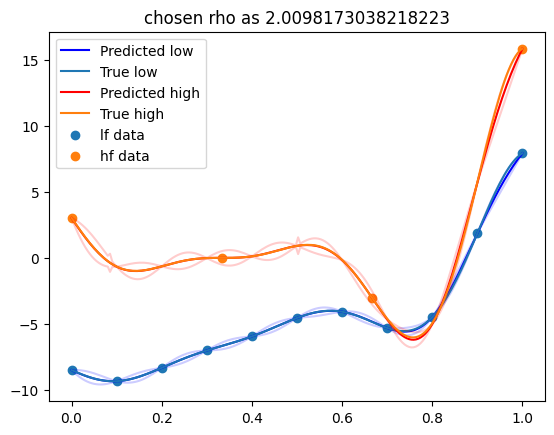

In [16]:

def filter_by_fidelity(query_points: TensorType):

    input_points = query_points[:, :-1]  # [..., D+1]
    fidelities = query_points[:, -1:]  # [..., 1]
    lowfi_mask = (fidelities[:, 0] == 0.)
    ind_lowfi = tf.where(lowfi_mask)[:, 0]
    highfi_mask = (fidelities[:, 0] == 1.)
    ind_highfi = tf.where(highfi_mask)[:, 0]
    lowfi_points = tf.gather(input_points, ind_lowfi, axis=0)
    highfi_points = tf.gather(input_points, ind_highfi, axis=0)
    return lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi

# Replace this with your own observer
def my_simulator(x_input, fidelity):
    # this is a dummy objective
    f = 0.5 * ((6.0*x_input-2.0)**2)*tf.math.sin(12.0*x_input - 4.0) + 10.0*(x_input -1.0)
    return f + fidelity * (f - 20.0*(x_input -1.0))


def observer(x):
    # last dimension is the fidelity value
    x_input = x[..., :-1]
    x_fidelity = x[...,-1:]

    # note: this assumes that my_simulator broadcasts, i.e. accept matrix inputs.
    # If not you need to replace this by a for loop over all rows of "input"
    observations = my_simulator(x_input, x_fidelity)
    return trieste.data.Dataset(x, observations)


num_init = 12
input_dim = 1
lb = np.zeros(input_dim)
ub = np.ones(input_dim)

input_search_space = trieste.space.Box(lb, ub)
fidelity_search_space = trieste.space.DiscreteSearchSpace(np.array([0., 1.]).reshape(-1, 1))
search_space = trieste.space.TaggedProductSearchSpace([input_search_space, fidelity_search_space],
                                                      ["input", "fidelity"])

X = tf.linspace(0,1,11)[:, None]
initial_sample_low = tf.concat([X,tf.zeros_like(X)],1)
X = tf.linspace(0,1,4)[:, None]
initial_sample_high = tf.concat([X,tf.ones_like(X)],1)
initial_sample = tf.concat([initial_sample_low,initial_sample_high],0)
initial_data = observer(initial_sample)

lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi = filter_by_fidelity(initial_data.query_points)
lf_data = Dataset(lowfi_points, tf.gather(initial_data.observations, ind_lowfi))
hf_data = Dataset(highfi_points, tf.gather(initial_data.observations, ind_highfi))

low_fidelity_gpr = GaussianProcessRegression(build_gpr(lf_data, input_search_space,  likelihood_variance = 1e-5, kernel_priors=False))
high_fidelity_gpr = GaussianProcessRegression(build_gpr(hf_data, input_search_space, likelihood_variance = 1e-5, kernel_priors=False)) # ignore this


model = AR1(
    lowest_fidelity_signal_model = low_fidelity_gpr,
    fidelity_residual_models = [high_fidelity_gpr],

)
model.update(initial_data)
model.optimize(initial_data)


X = tf.linspace(0,1,200)[:, None]
X_low = tf.concat([X,tf.zeros_like(X)],1)
X_high = tf.concat([X,tf.ones_like(X)],1)
mean, var = model.predict(X_low)
plt.plot(X,mean, label="Predicted low", color="blue")
plt.plot(X,mean+1.96*tf.math.sqrt(var),color="blue",alpha=0.2)
plt.plot(X,mean-1.96*tf.math.sqrt(var), color="blue", alpha=0.2)
plt.plot(X,observer(X_low).observations, label="True low")
mean, var = model.predict(X_high)
plt.plot(X,mean, label="Predicted high", color="red")
plt.plot(X,mean+1.96*tf.math.sqrt(var),color="red",alpha=0.2)
plt.plot(X,mean-1.96*tf.math.sqrt(var), color="red", alpha=0.2)
plt.plot(X,observer(X_high).observations, label="True high")
plt.scatter(lowfi_points, tf.gather(initial_data.observations, ind_lowfi), label="lf data")
plt.scatter(highfi_points, tf.gather(initial_data.observations, ind_highfi), label="hf data")
plt.legend()
plt.title(f"chosen rho as {model.rho[1].numpy()}")